# Autoencoder

## imports

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## utility functions

In [2]:
def show_image(img, target):
    print("Target is: ", target)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

## data steps

### load the data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### preprocess the data

In [4]:
# we assume that at least one pixel is lit up in the image since mnist is a cleaned dataset
# this means we can check max value to see if we have preprocessed the data already
if(np.max(X_train) > 1):
    X_train = X_train / 255
if(np.max(X_test) > 1):
    X_test = X_test / 255

Target is:  5


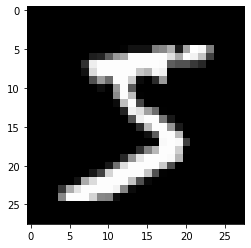

In [5]:
show_image(X_train[0], y_train[0])

In [6]:
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(51000, 28, 28, 1) (51000,) (9000, 28, 28, 1) (9000,) (10000, 28, 28, 1) (10000,)


## create the model

In [7]:
LATENT_SIZE = 32
IMG_SIZE = X_train.shape[1]

### dense model

In [8]:
class DenseAutoencoder(models.Model):
    def __init__(self, latent_dim, img_size):
        super(DenseAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        # encoder model
        self.encoder = models.Sequential([
            layers.Flatten(),
            layers.Dense(self.latent_dim, activation='relu')
        ])
        # decoder model
        self.decoder = models.Sequential([
            layers.Dense(self.img_size*self.img_size, activation='sigmoid'),
            layers.Reshape((self.img_size, self.img_size, 1))
        ])
    
    def call(self, X):
        return self.decoder(self.encoder(X))

### convolutional model

In [9]:
class ConvolutionalAutoencoder(models.Model):
    def __init__(self, img_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.img_size = img_size
        # encoder model
        self.encoder = models.Sequential([
            layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
            layers.Flatten()
        ])
        # decoder model
        self.decoder = models.Sequential([
            layers.Reshape((7, 7, 1)),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'),
        ])
    
    def call(self, X):
        return self.decoder(self.encoder(X))

## train the dense model

In [10]:
dense_autoencoder = DenseAutoencoder(LATENT_SIZE, IMG_SIZE)
dense_autoencoder.compile(loss='mse', optimizer='adam', metrics=['mae'])
dense_autoencoder.build((None,IMG_SIZE,IMG_SIZE,1))
dense_autoencoder.summary()

Model: "dense_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32)                25120     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0, patience=2, factor=0.5)
hist = dense_autoencoder.fit(X_train, X_train,
                             batch_size=16,
                             shuffle=True, 
                             epochs=20,
                             validation_data=(X_val,X_val),
                             validation_batch_size=16,
                             callbacks=[early_stopping, reduce_lr])

Epoch 1/20
3188/3188 [==============================] - 5s 1ms/step - loss: 0.0272 - mae: 0.0763 - val_loss: 0.0139 - val_mae: 0.0470 - lr: 0.0010
Epoch 2/20
3188/3188 [==============================] - 4s 1ms/step - loss: 0.0121 - mae: 0.0411 - val_loss: 0.0112 - val_mae: 0.0380 - lr: 0.0010
Epoch 3/20
3188/3188 [==============================] - 4s 1ms/step - loss: 0.0110 - mae: 0.0368 - val_loss: 0.0109 - val_mae: 0.0360 - lr: 0.0010
Epoch 4/20
3188/3188 [==============================] - 4s 1ms/step - loss: 0.0107 - mae: 0.0357 - val_loss: 0.0107 - val_mae: 0.0355 - lr: 0.0010
Epoch 5/20
3188/3188 [==============================] - 5s 2ms/step - loss: 0.0106 - mae: 0.0353 - val_loss: 0.0107 - val_mae: 0.0352 - lr: 0.0010
Epoch 6/20
3188/3188 [==============================] - 5s 1ms/step - loss: 0.0105 - mae: 0.0350 - val_loss: 0.0104 - val_mae: 0.0348 - lr: 0.0010
Epoch 7/20
3188/3188 [==============================] - 4s 1ms/step - loss: 0.0104 - mae: 0.0348 - val_loss: 0.0105 - 

In [12]:
dense_autoencoder.evaluate(X_test, X_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0095 - mae: 0.0332


[0.009538433514535427, 0.033170778304338455]

## train convolutional autoencoder

In [13]:
convolutional_autoencoder = ConvolutionalAutoencoder(IMG_SIZE)
convolutional_autoencoder.compile(loss='mse', optimizer='adam', metrics=['mae'])
convolutional_autoencoder.build((None,IMG_SIZE,IMG_SIZE,1))
convolutional_autoencoder.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 49)                5089      
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         5089      
                                                                 
Total params: 10,178
Trainable params: 10,178
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0, patience=2, factor=0.5)
hist = convolutional_autoencoder.fit(X_train, X_train,
                                     batch_size=16,
                                     shuffle=True, 
                                     epochs=20,
                                     validation_data=(X_val,X_val),
                                     validation_batch_size=16,
                                     callbacks=[early_stopping, reduce_lr])

Epoch 1/20
3188/3188 [==============================] - 59s 18ms/step - loss: 0.0193 - mae: 0.0536 - val_loss: 0.0126 - val_mae: 0.0384 - lr: 0.0010
Epoch 2/20
3188/3188 [==============================] - 61s 19ms/step - loss: 0.0118 - mae: 0.0371 - val_loss: 0.0113 - val_mae: 0.0359 - lr: 0.0010
Epoch 3/20
3188/3188 [==============================] - 60s 19ms/step - loss: 0.0110 - mae: 0.0352 - val_loss: 0.0107 - val_mae: 0.0348 - lr: 0.0010
Epoch 4/20
3188/3188 [==============================] - 56s 18ms/step - loss: 0.0105 - mae: 0.0341 - val_loss: 0.0103 - val_mae: 0.0335 - lr: 0.0010
Epoch 5/20
3188/3188 [==============================] - 56s 17ms/step - loss: 0.0102 - mae: 0.0333 - val_loss: 0.0100 - val_mae: 0.0331 - lr: 0.0010
Epoch 6/20
3188/3188 [==============================] - 58s 18ms/step - loss: 0.0099 - mae: 0.0328 - val_loss: 0.0098 - val_mae: 0.0329 - lr: 0.0010
Epoch 7/20
3188/3188 [==============================] - 52s 16ms/step - loss: 0.0097 - mae: 0.0323 - val_l

In [15]:
convolutional_autoencoder.evaluate(X_test, X_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0079 - mae: 0.0286


[0.00786722544580698, 0.028633154928684235]

# test the autoencoder results

 We can see the mean squared error and the mean absolute errors but lets see how the reconstructions look

In [16]:
def show_results(original, recons):
    plt.figure(figsize=(20, 4))
    n = len(original)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recons[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [17]:
originals = X_test[np.random.choice(len(X_test), 5), :, :, :]
dense_recons = dense_autoencoder.predict(originals)
conv_recons = convolutional_autoencoder.predict(originals)

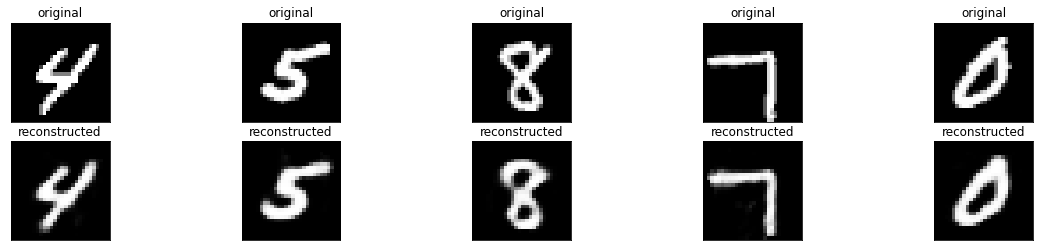

In [18]:
show_results(originals, dense_recons)

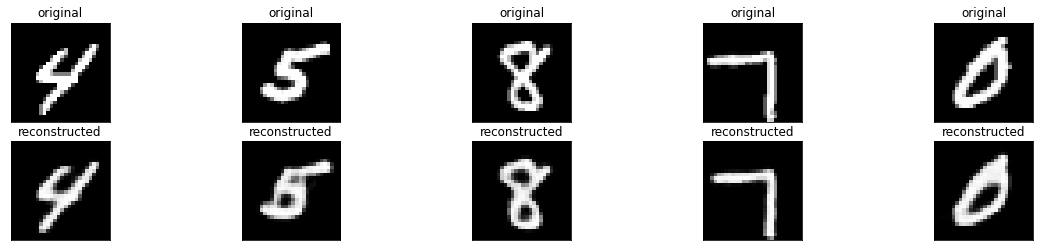

In [19]:
show_results(originals, conv_recons)

## Conv model visually outpreforms the dense model
this is kind of expected, even though it has less trainable parameters, convoluions leverage spatial awarness by applying filters accross the image to extract more meaningful features than a dense model might. It also creates a deeper model with far fewer parameters

## analyze the dense vectors with TSNE
tsne is a dimensionality reduction technique that attempts to project the dataponts in a lower dimension while maintaining the relative distances between points. We would like to see a situation in which images of the same label are in similar points in the TSNE reduced dimensions

In [20]:
# indecies = np.random.choice(len(X_test), 5)
# images, labels = X_test[indecies,:,:,:], y_test[indecies]
vector_space = convolutional_autoencoder.encoder(X_test)
print(vector_space.shape)

(10000, 49)


C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

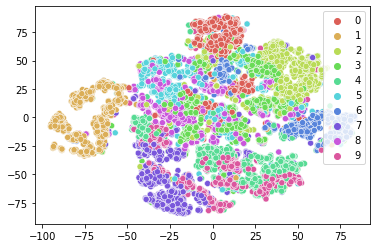

In [21]:
tsne = TSNE(n_components=2, random_state=0)
reduced_dims = tsne.fit_transform(vector_space)

sns.scatterplot(x=reduced_dims[:,0], y=reduced_dims[:,1], hue=y_test, palette=sns.hls_palette(10), legend='full')

C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

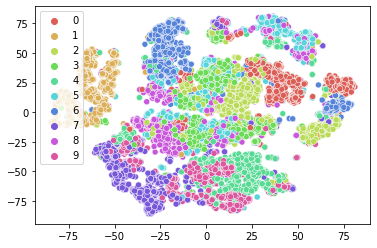

In [22]:

vector_space_norm = StandardScaler().fit_transform(vector_space)

tsne_norm = TSNE(n_components=2, random_state=0)
reduced_dims_norm = tsne_norm.fit_transform(vector_space_norm)

sns.scatterplot(x=reduced_dims_norm[:,0], y=reduced_dims_norm[:,1], hue=y_test, palette=sns.hls_palette(10), legend='full')

<AxesSubplot:>

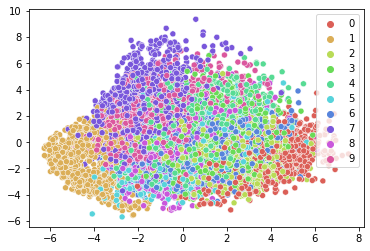

In [25]:
pca = PCA(n_components=2)
pca_dims = pca.fit_transform(vector_space_norm)
sns.scatterplot(x=pca_dims[:,0], y=pca_dims[:,1], hue=y_test, palette=sns.hls_palette(10), legend='full')

C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiern\anaconda3\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

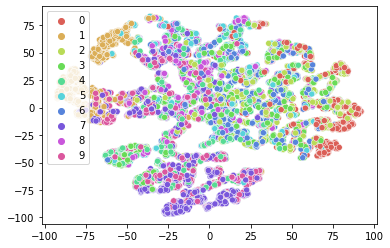

In [26]:
pca_ens = PCA(n_components=30)
tsne_ens = TSNE(n_components=2, random_state=0)
pca_ens_dim = pca.fit_transform(vector_space_norm)
tsne_ens_dim = tsne_norm.fit_transform(pca_ens_dim)
sns.scatterplot(x=tsne_ens_dim[:,0], y=tsne_ens_dim[:,1], hue=y_test, palette=sns.hls_palette(10), legend='full')